In [ ]:
import torch
from matplotlib import pyplot as plt
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    # plt.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [ ]:
# train_ch6所需的所有组件
import torch
from torch import nn
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline
import torchvision
from torch.utils import data
from torchvision import transforms

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 更新器
def sgd(params, lr, batch):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 计时器
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times)/len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()


# 精准度的计算
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
          device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
              # BERT微调所需
              X = [x.to(device) for x in X]
            else:
              X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 参数储存器
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 画图部分
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# mini-batch取数据
def get_dataloader_workers():
  #使用四个线程
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()), data.DataLoader(mnist_test, batch_size, shuffle=False,
                num_workers=get_dataloader_workers()))

def try_gpu(i=0):
  """如果存在，则返回gpu(i)，否则返回cpu()"""
  if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
  return torch.device('cpu')


  # 训练
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
import torch
from torch import nn

In [ ]:
# 注意力汇聚
def plot_kernel_reg(y_hat):
    # plt.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
    #          xlim=[0, 5], ylim=[-1, 5])
    plt.plot(x_test, y_truth, 'x', 'y')
    plt.plot(x_train, y_train, 'o', alpha=0.5);

class NWKernelRegression(nn.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

  def forward(self, queries, keys, values):
    queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
    self.attention_weights = nn.functional.softmax(
        -0.5 * ((queries - keys) * self.w)**2, dim=1
    )
    return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)


In [ ]:
# scoring function
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)
  else:
    shape = X.shape
    if valid_lens.dim()==1:
      valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
      valid_lens = valid_lens.reshape(-1)
    X = sequence_mask(X.reshape(-1, X.shape[-1]), valid_lens, value=-1e6)
    return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
  def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.w_v = nn.Linear(num_hiddens, 1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

import math
class DotProductAttention(nn.Module):
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 文本处理组件
import torch
# from d2l import torch as d2l
import collections
import re
# from d2l import torch as d2l

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens==None:
            tokens = []
        if reserved_tokens==None:
            reserved_tokens = []
#         按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in
                           enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs



def count_corpus(tokens):
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
# 9.5 机器翻译与数据集
def read_data_nmt():
  with open('/content/drive/MyDrive/fra.txt', 'r', encoding='utf-8') as f:
    return f.read()

def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def tokenize_nmt(text, num_examples=None):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))
  return source, target

from matplotlib import pyplot as plt
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    # plt.set_figsize()
    plt.figure(figsize=(8,5), dpi=80)
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [ ]:
# 9.6 编码器-解码器架构
from torch import nn

class Encoder(nn.Module):
  def __init__(self, **kwargs):
    super(Encoder, self).__init__(**kwargs)

  def forward(self, X, *args):
    raise NotImplementedError

class Decoder(nn.Module):
  def __init__(self, **kwargs):
    super(Decoder, self).__init__(**kwargs)

  def init_state(self, enc_outputs, *args):
    raise NotImplementedError

  def forward(self, X, state):
    raise NotImplementedError

class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, **kwargs):
    super(EncoderDecoder, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args)
    return self.decoder(dec_X, dec_state)

In [ ]:
# 9.7 seq2seq实现
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
               dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

  def forward(self, X, *args):
    X = self.embedding(X).permute(1, 0, 2)
    output, state = self.rnn(X)
    return output, state

class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # print(unweighted_loss.shape)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param:
          nn.init.xavier_uniform_(m._parameters[param])

  net.apply(xavier_init_weights)
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss = MaskedSoftmaxCELoss()
  net.train()
  animator = Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
  for epoch in range(num_epochs):
    timer = Timer()
    metric = Accumulator(2)
    for batch in data_iter:
      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                         device=device).reshape(-1, 1)
      dec_input = torch.cat([bos, Y[:, :-1]], 1)
      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      l.sum().backward()
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum()
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)
    if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

def predict_seq2seq(net, src_sentences, src_vocab, tgt_vocab,
                    num_steps, device, save_attention_weights=False):
  net.eval()
  src_tokens = src_vocab[src_sentences.lower().split(' ')] + [src_vocab['<eos>']]
  enc_valid_len = torch.tensor([len(src_tokens)], device=device)
  src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
  # 添加批量轴
  enc_X = torch.unsqueeze(
      torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0
  )
  enc_outputs = net.encoder(enc_X, enc_valid_len)
  dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
  dec_X = torch.unsqueeze(
      torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0
  )
  output_seq, attention_weight_seq = [], []
  for _ in range(num_steps):
    Y, dec_state = net.decoder(dec_X, dec_state)
    dec_X = Y.argmax(dim=2)
    # print(f'shape of Y is {Y.shape}, shape of dec_X is {dec_X.shape}')
    pred = dec_X.squeeze(dim=0).type(torch.int32).item()
    # print(f'pred is {pred},pred before is {dec_X.squeeze(dim=0).type(torch.int32)}')
    if save_attention_weights:
        attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
    if pred == tgt_vocab['<eos>']:
        break
    output_seq.append(pred)
  return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
class AdditiveAttention(nn.Module):
  def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
    super(AdditiveAttention, self).__init__(**kwargs)
    self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
    self.w_v = nn.Linear(num_hiddens, 1, bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens):
    queries, keys = self.W_q(queries), self.W_k(keys)
    features = queries.unsqueeze(2) + keys.unsqueeze(1)
    features = torch.tanh(features)
    scores = self.w_v(features).squeeze(-1)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
# 10.4 Bahdanau注意力模型
class AttentionDecoder(Decoder):
  def __init__(self, **kwargs):
    super(AttentionDecoder, self).__init__(**kwargs)

  @property
  def attention_weights(self):
    raise NotImplementedError

class Seq2SeqLSTMEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
               dropout=0, **kwargs):
    super(Seq2SeqLSTMEncoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

  def forward(self, X, *args):
    X = self.embedding(X).permute(1, 0, 2)
    output, state = self.rnn(X)
    return output, state

class Seq2SeqAttentionDecoder(AttentionDecoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens,num_hiddens, num_hiddens, dropout
        )
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), (hidden_state, hidden_state), enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
          query = torch.unsqueeze(hidden_state[0][-1], dim=1)
          context = self.attention(
              query, enc_outputs, enc_outputs, enc_valid_lens
          )
          x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
          out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
          outputs.append(out)
          self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([2, 4, 16]))

loss 0.022, 7453.7 tokens/sec on cuda:0


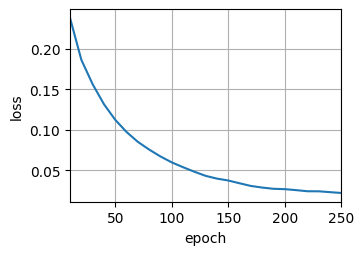

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je suis partie .,  bleu 0.000
he's calm . => il est malade .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [ ]:
# 多头注意力机制
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])



def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
# 10.7 Transformer
import math
import pandas as pd
import torch
from torch import nn

# 基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
    super(EncoderBlock, self).__init__(**kwargs)
    self.attention = MultiHeadAttention(
        key_size, query_size, value_size, num_hiddens, num_heads, dropout
    )
    self.addnorm1 = AddNorm(norm_shape, dropout)
    self.ffn = PositionWiseFFN(
        ffn_num_input, ffn_num_hiddens, num_hiddens
    )
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

loss 0.032, 8670.9 tokens/sec on cuda:0


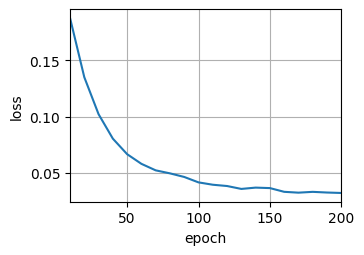

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [16]:
import numpy as np

def sift(li, low, high):
  temp = li[low]
  i = low
  j = 2 * i + 1
  while i <= high:
    if j + 1 <= high and li[j] < li[j+1]:
      j += 1
    if j <= high and li[j] > temp:
      li[i] = li[j]
      i = j
      j = 2 * i + 1
    else:
      break
    print(li, i)
  li[i] = temp
  print(li)

def topk(data, k):
  for

In [17]:
x = [2, 7, 8, 5, 3, 7, 2, 4, 3, 9]
sift(x, 0, 7)

[8, 7, 8, 5, 3, 7, 2, 4, 3, 9] 2
[8, 7, 7, 5, 3, 7, 2, 4, 3, 9] 5
[8, 7, 7, 5, 3, 2, 2, 4, 3, 9]


In [45]:
def merge(li, low, mid, high):
  lp, rp = low, mid + 1
  temp = []
  while lp <= mid and rp <= high:
    if li[lp] <= li[rp]:
      temp.append(li[lp])
      lp += 1
    else:
      temp.append(li[rp])
      rp += 1
    # print(rp, lp)
  while lp <= mid:
    temp.append(li[lp])
    lp += 1
  while rp <= high:
    temp.append(li[rp])
    rp += 1
  li[low:high+1] = temp
  # print(li)

def merge_sort(li, low, high):
  if low < high:
    print(low, high)
    mid = (high-low)//2
    merge_sort(li, low, mid)
    merge_sort(li, mid+1, high)
    merge(li, low, mid, high)
    print(li)



In [36]:
merge([1, 3, 4, 5, 8, 10, 2, 3, 5, 6, 9], 0, 5, 10)

6 1
7 1
7 2
8 2
8 3
8 4
9 4
10 4
10 5
11 5
[1, 2, 3, 3, 4, 5, 5, 6, 8, 9, 10]


In [ ]:
x = [2, 7, 8, 5, 3, 7, 2, 4, 3, 9]
merge_sort(x, 0, 9)

0 9
0 4
0 2
0 1
[2, 7, 8, 5, 3, 7, 2, 4, 3, 9]
[2, 7, 8, 5, 3, 7, 2, 4, 3, 9]
3 4
1 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 4
2 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
RecursionError: maximum recursion depth exceeded while calling a Python object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-4368d40884b7>", line 2, in <cell line: 2>
    merge_sort(x, 0, 9)
  File "<ipython-input-45-218561f435e2>", line 25, in merge_sort
    merge_sort(li, low, mid)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  [Previous line repeated 95

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
RecursionError: maximum recursion depth exceeded while calling a Python object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-4368d40884b7>", line 2, in <cell line: 2>
    merge_sort(x, 0, 9)
  File "<ipython-input-45-218561f435e2>", line 25, in merge_sort
    merge_sort(li, low, mid)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  File "<ipython-input-45-218561f435e2>", line 26, in merge_sort
    merge_sort(li, mid+1, high)
  [Previous line repeated 95